# Statistical procedure for the data of the Higgs boson

The following procedure is gathered from the CMS - NOTE 2011-005, and is the statistical approach used to do an hypothesis test to determine wether the results for the Higgs boson mass produced by the data is only created by background or an actual signal in combination with background.

We make the signal and the background functions of the nuiance parameter $\theta$, and denote them $s\left(\theta\right)$ and $b\left(\theta\right)$ respectfully.

1. Construct the likelyhood function
$$\mathcal{L}\left(\mbox{data}|\mu,\theta\right) = \mbox{Poisson}\left(\mbox{data}|\mu \cdot s\left(\theta\right) + b\left(\theta\right)\right)\cdot p\left(\tilde{\theta}|\theta\right)$$

* Data represents either actual experimental observation or pseudo-data used to construct sampling distributions

* $\mu$ is the signal strength modifier and $\theta$ represents the full suite of nuiance parameters

* Poissons(data|$\mu s + b$) stands for a product of Poisson probabilities to observe $n_i$ events in bins $i$:
$$\prod_{i} \frac{\left(\mu s_i + b_i\right)^{n_i}}{n_i !} e^{-\mu s_i - b_i}$$

2. To compare the compability of the data with the background -only and signal + background hypothesis, the test statistic $$\tilde{q_{\mu}} =  - 2ln \frac{\mathcal{L}\left(\mbox{data}|\mu,\hat{\theta_{\mu}}\right)}{\mathcal{L}\left(\mbox{data}|\hat{\mu},\hat{\theta}\right)},$$ with $0 \leq \hat{\mu} \leq \mu$. Where $\hat{\theta_{\mu}}$ refers to the conditional maximum likelyhood estimate of $\theta$, given the signal strength paramter $\mu$ and data. $\hat{\mu}$ and $\hat{\theta}$ correspond to the global maximum of the likelihood.

3. Find the observed value of the test statisitc $\tilde{q_{\mu}^{obs}}$ for the given signal strength modifier $\mu$ under test.

4. Find values of the nuisance paramters $\hat{\theta_{o}^{obs}}$ and $\hat{\theta}_{\mu}^{\mbox{obs}}$ best describing the experimentally observed data, for the background only and signal + background hypothesis, respectively. 

5. Use (a bit unsure because, in the CMS document it says generate toy monte carlo pseudo-data, but I assume that part is done, so I assume we are just supposed to use the generated one) the generated pseudo-data to construct $pdf$s $f\left(\tilde{q_{\mu}}|\mu, \hat{\theta}_{\mu}^{obs}\right)$ and $f\left(\tilde{q_{\mu}}|0, \hat{\theta}_{0}^{obs}\right)$ assuming a signal with strength $\mu$ in the signal + background hypothesis and for the background only hypothesis ($\mu = 0$).

6. Having constructed $f\left(\tilde{q_{\mu}}|\mu, \hat{\theta}_{\mu}^{obs}\right)$ and $f\left(\tilde{q_{\mu}}|0, \hat{\theta}_{0}^{obs}\right)$ distributions, define two p-values to be associated with the actual observation for the signal + background and background-only hypothesis, $p_{\mu}$ and $p_b$:
$$p_{\mu} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{signal + background}\right) = \int_{\tilde{q}_{\mu}^{obs}}^{infty} f\left(\tilde{q}_{\mu}|\mu, \hat{\theta}_{\mu}^{obs}\right) d\tilde{q_{\mu}} $$

$$1- p_{b} = P\left(\tilde{q_{\mu}} \geq \tilde{q}_{\mu}^{obs}|\mbox{background only}\right) = \int_{\tilde{q}_{+0}^{obs}}^{infty} f\left(\tilde{q}_{\mu}|0, \hat{\theta}_{0}^{obs}\right) d\tilde{q_{\mu}}$$

and calculate $CL_{s}\left(\mu\right) = \frac{p_{\mu}}{1-p_{b}}$.

7. If, for $\mu = 1$, $CL_s \leq \alpha$, we would state that the SM Higgs boson is excluded with (1 - $\alpha$) confidence level.

8. To quote the 95$\%$ Confidence Level upper limit on $\mu$, to be further denoted as $\mu^{95\%CL}$ we adjust $\mu$ until we reach $CL_s = 0.05$.


Further the procedure states that the test statistic used for the higgs boson is $q_{\mu}$ with $\hat{\mu} \geq 0$. (see expression for $q_{\mu}$ above.)

## Imports

In [98]:
# Useful packages
import pandas as pd
import scipy.stats as ss
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy as sp
import pyhf
from   matplotlib.pyplot import figure
from   tqdm import tqdm
import scipy.integrate as integrate
import scipy.special as special
import seaborn as sns
import matplotlib.patches as mpatches

## Uploading data and checking the correspondence between data and simulations

considering only m>100 GeV

In [2]:
sim_signal_counts     = np.load(r'signal_counts.npy')
sim_background_counts = np.load(r'background_counts.npy')
true_counts           = np.load(r'true_counts.npy')
bin_counts            = np.load(r'bins.npy')

Text(0, 0.5, 'Counts')

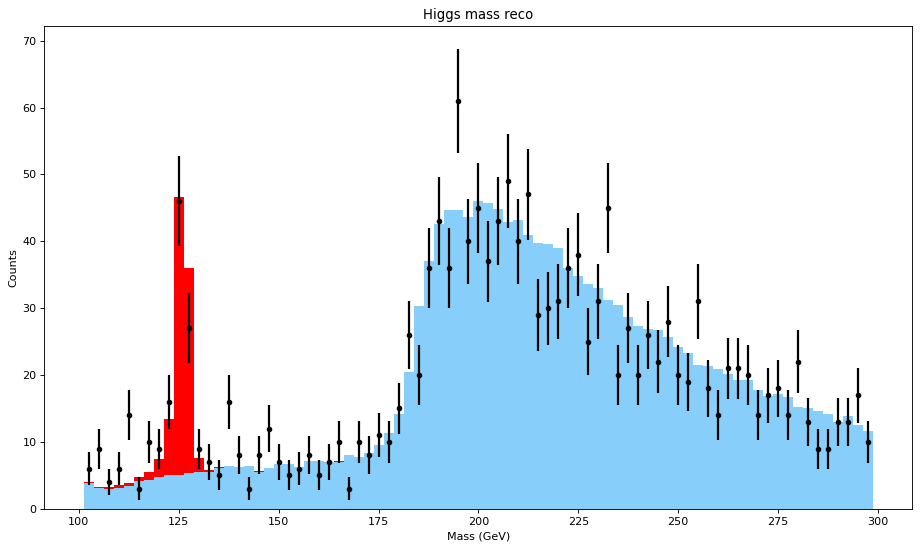

In [3]:
figure(figsize=(14, 8), dpi=80)

width      = [bin_counts[1] - bin_counts[0]]
bincenters = ( bin_counts[1:] + bin_counts[:-1] + width ) / 2

plt.errorbar( bincenters, true_counts,
              yerr   = np.sqrt(true_counts),
              markersize  = 8,
              fmt    = '.', 
              color  = 'black',
              linewidth = 2)
plt.bar(bin_counts[1:,], sim_background_counts + sim_signal_counts , 
        color = 'red', alpha = 1, 
        width = width  )
plt.bar(bin_counts[1:,], sim_background_counts , 
        color = 'lightskyblue', alpha = 1, 
        width = width )
plt.title("Higgs mass reco")
plt.xlabel("Mass (GeV)")
plt.ylabel("Counts")

## Defining necessary functions

In [4]:
# We can assume the data we are getting in is an array of discrete counts;
# The likelihood function for each bin is given by the poisson distribution
# pmf(k, mu, loc=0)

# log of likelihood function to avoid underflow

def log_likelihood(params, s = sim_signal_counts,
                           b = sim_background_counts,
                           n = true_counts):
    """ 
    params[0] = signal strength parameter mu
    params[1] = nuisance parameter theta
    s         = number of expected signal events in bin i 
    b         = number of expected background events in bin i 
    n         = number of real events in bin i 
    """

    nu = (params[0]*s) + b
    log_poiss_pdf = sum(np.log(ss.poisson.pmf(n,nu)))
    theta_pdf     = ss.norm.pdf(x = params[1], loc = 0, scale = 0.15)
  
    return log_poiss_pdf + np.log(theta_pdf)

# we construct the test statistic q ̃_mu based on the profile likelihood ratio:

def q_tilde_mu(mu_1, theta1, mu_2, theta2,
                n = true_counts, 
                s = sim_signal_counts, 
                b = sim_background_counts,
                func=log_likelihood):
    
    log_val = func([mu_1, theta1],s, b, n) - func([mu_2, theta2],s, b, n)
    
    return -2*log_val 


# Functions for generating toy Monte Carlo pseudo-data to 
# construct pdfs f(q^~_μ |μ) and f (q^ ̃_μ |0 )
# assuming a signal with strength μ in the signal+background 
# hypothesis and for the
# background-only hypothesis (μ = 0). 

def create_toy(mu, s, b ):
    """
    Return a random Poisson distributed value
    with mu*s + b as its expected value
    """
        
    return ss.poisson.rvs((mu*s)+b,size=1)


def create_toy_distr(mu,s,b,func = create_toy):
    
    """
    Generate for each bin a random Poisson 
    distributed values in according to the 
    counts for simulated signal and background 
    """
    
    toys_list = np.zeros(len(s))
    for i in range(len(s)):
        toys_list[i] = func(mu,s[i],b[i])
        
    return toys_list


# loop over all the different toy-datasets
# and calculate the optimal mu for each of them

def get_params_max( df, s, b ):
   
    n_toys  = len(df.iloc[:,0])
    mu_s    = np.zeros(n_toys)
    thets_s = np.zeros(n_toys)

    for i in range(n_toys):
        fun = lambda x: -log_likelihood(x, s, b, n = df.iloc[i,:])
        params_opt_i  = sp.optimize.minimize(fun, (0.5, 0.5), bounds=((0,1),(-5, 5)))
        mu_s[i],  thets_s[i] = params_opt_i["x"]
    
    return mu_s, thets_s


### Finding the q-values of our original data

Finding $\mu$ that maximize the likelihood function in [0,1] is equal to find $\mu$ that minimize the likelihood function.

We used scipy.optimize.minimize to find the minimum of -log.likelihood 

In [5]:
fun = lambda x: -log_likelihood(x)

params_opt = sp.optimize.minimize(fun,(0.5, 0.5),bounds=((0,1),(-1,1)))

mu_max, theta_max = params_opt["x"]


print("The best fit value of mu for our original data is: ", mu_max)
print("The best fit value of theta for our original data is: ", theta_max)

mu    = np.linspace( 0, 1, 100)
theta = np.linspace(-1, 1, 100)


likelihood_val = np.zeros((len(mu), len(theta)))

for i in range(len(mu)):
    for j in range(len(theta)):
        Z = log_likelihood([mu[i],theta[j]])

        likelihood_val[i][j] = Z


The best fit value of mu for our original data is:  0.9571142266134196
The best fit value of theta for our original data is:  -4.5146978451990683e-07


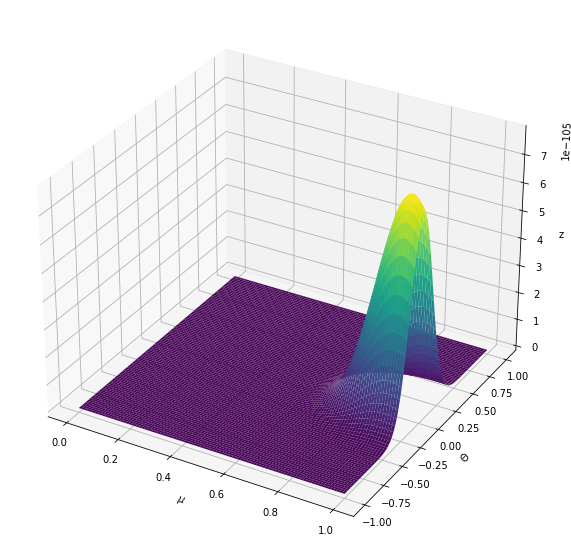

In [6]:
X, Y = np.meshgrid( theta, mu )

ax   = plt.figure( figsize = ( 15, 10 ) )

ax   = plt.axes( projection = '3d', 
                 label ='z' )

ax.plot_surface( Y, X, np.exp(likelihood_val), 
                 rstride = 1, 
                 cstride = 1,
                 cmap    = 'viridis',
                 edgecolor = 'none')
ax.set_xlabel( '$\mu$' )
ax.set_ylabel( '$\Theta$' )
ax.set_zlabel( 'z' );

In [303]:
mu     = np.linspace( 1, 0.1, 9)

In [304]:
# Find Theta_0_max obs and Theta_1_max obs:

fun    = lambda x:  - log_likelihood([0,x])
theta_0_obs  = sp.optimize.minimize(fun, 0.5, bounds=((-1, 1),))["x"]

mu     = np.linspace( 1, 0.1, 9)
theta_mu_obs = []
for i in mu:
    fun    = lambda x:  - log_likelihood([i,x])
    theta_mu_obs.append(sp.optimize.minimize(fun, 0.5, bounds=((-1, 1),))["x"])


In [305]:
# q_mu_obs

q_tilde_obs = []
q_0_toy     = []
q_mu_toy    = []

for i in tqdm(range(len(mu))):

    q = q_tilde_mu(mu[i], theta_mu_obs[i], mu_max, theta_max, true_counts)
    q_tilde_obs.append(q)
    N = 200

    q_0_mus  = np.zeros(N)
    q_mu_mus = np.zeros(N)
    for j in range(N):
        toys0 = pd.DataFrame(create_toy_distr(0,sim_signal_counts, sim_background_counts)).T
        toys1 = pd.DataFrame(create_toy_distr(mu[i],sim_signal_counts, sim_background_counts)).T
    
        mu_s_0, theta_s_0  = get_params_max(toys0,sim_signal_counts, sim_background_counts)
        mu_s_1, theta_s_1  = get_params_max(toys1,sim_signal_counts, sim_background_counts)
 
        q_0_mus[j]  = q_tilde_mu(mu[i],theta_0_obs,  mu_s_0, theta_s_0, toys0.iloc[0,:])
        q_mu_mus[j] = q_tilde_mu(mu[i],theta_mu_obs[i], mu_s_1, theta_s_1, toys1.iloc[0,:])
        
    q_0_toy.append(q_0_mus)
    q_mu_toy.append(q_mu_mus)



100%|███████████████████████████████████████████████████████████████████████| 9/9 [01:01<00:00,  6.84s/it]


### Costructing the pdf of $ \tilde{q}_{\mu} $ generating toy Monte Carlo pseudo-data

## Histogram representation of toy distributions for $\tilde{q}$

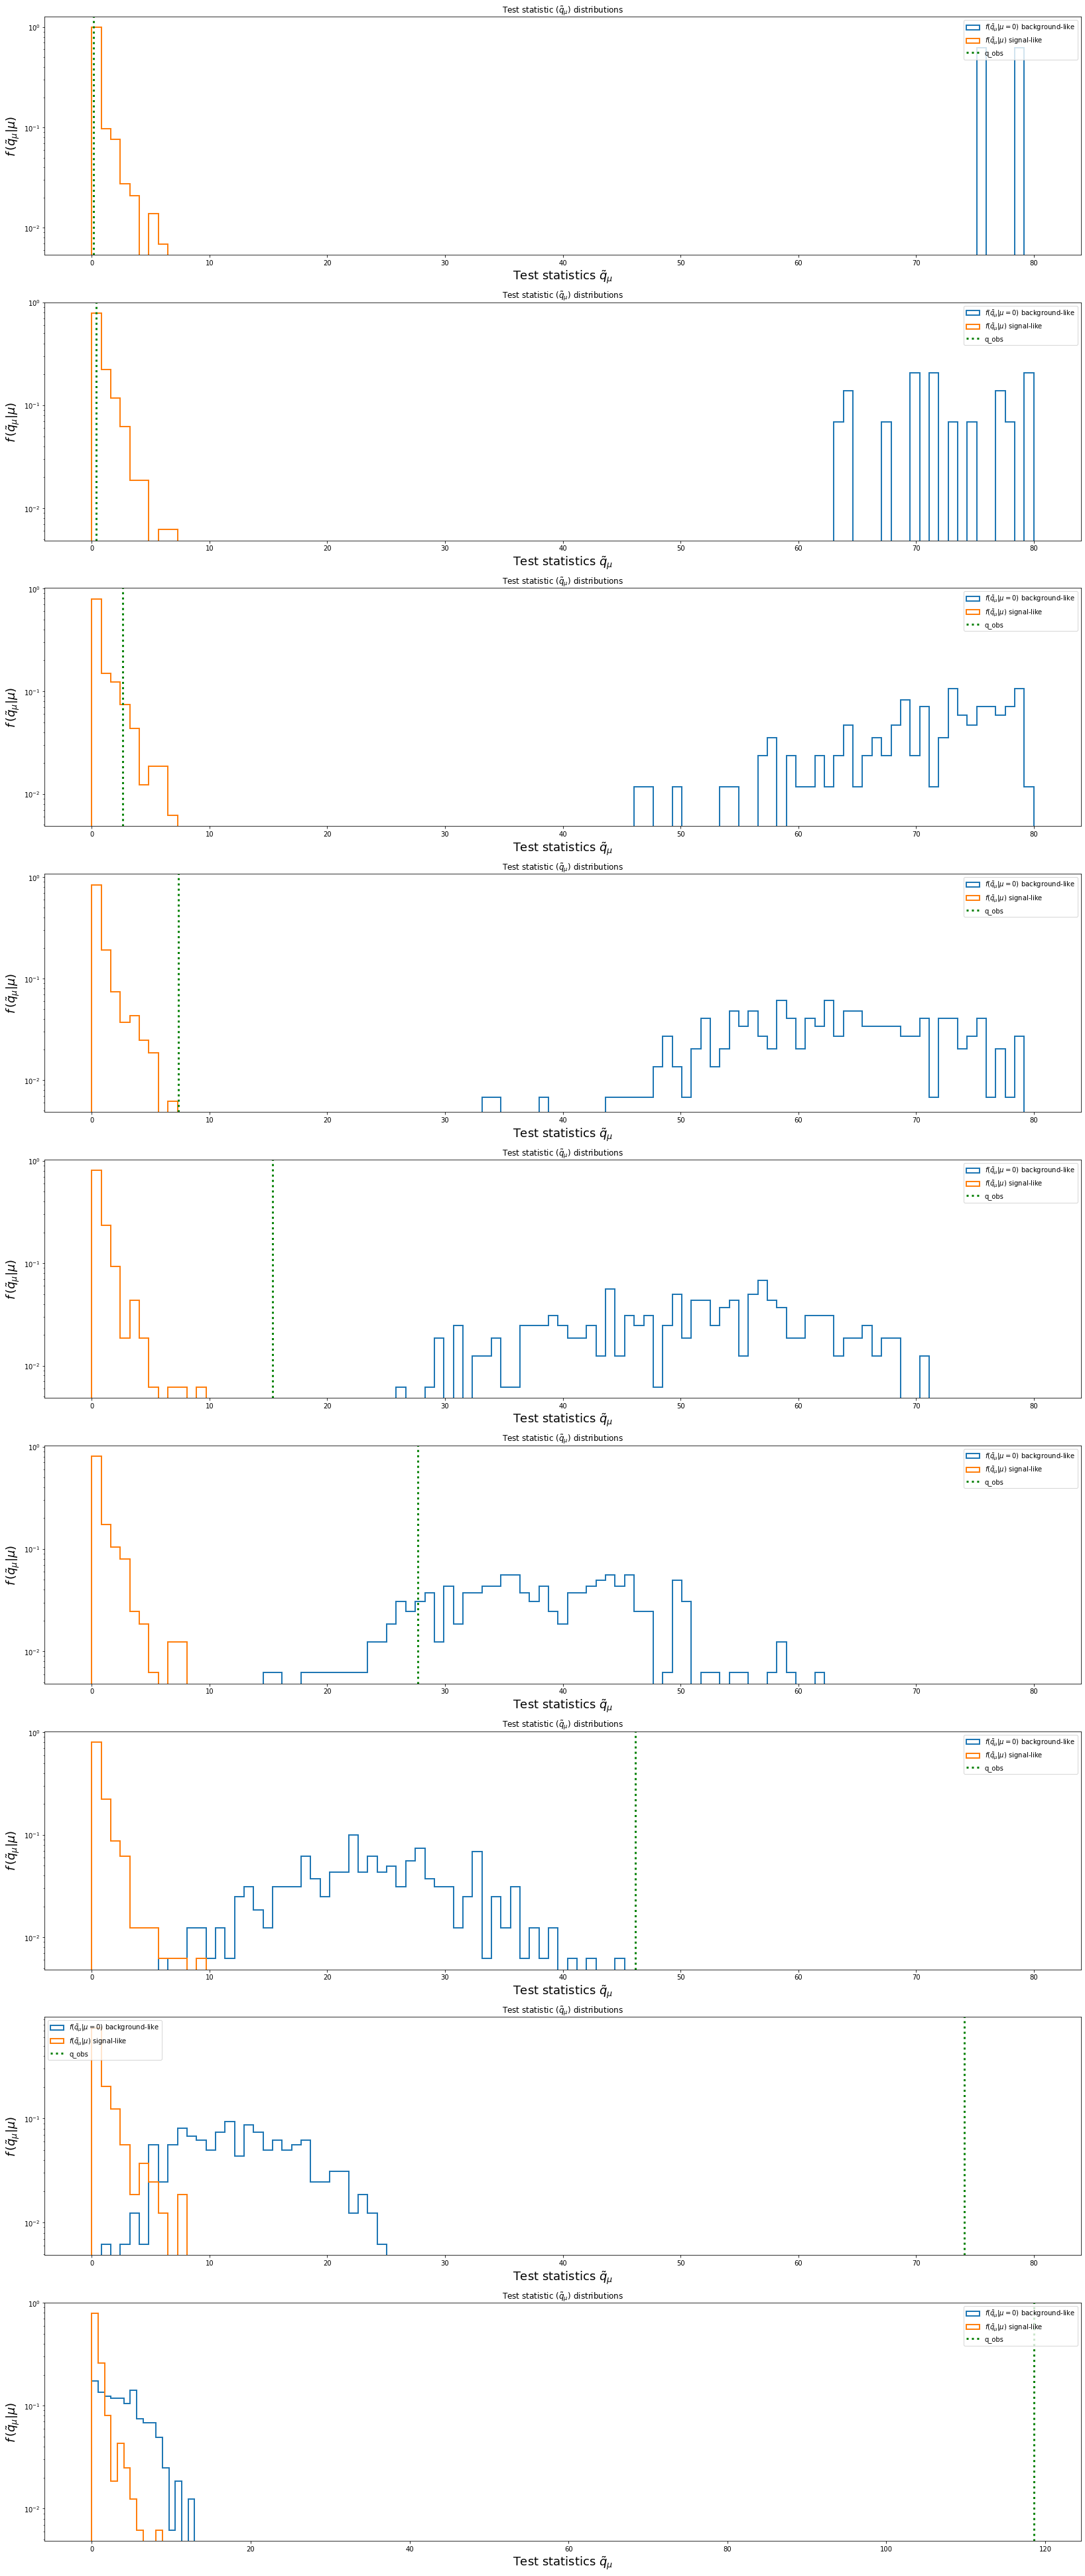

In [315]:
fig, ax = plt.subplots(9,1, figsize=(28,70))
for i,ax in zip(range(len(mu)), ax):
    bins = np.linspace(0, 80, 100)

    histogram_0 = ax.hist(q_0_toy[i], 
                       bins = bins,
                       histtype = 'step',
                       facecolor='c', 
                       density=True,
                       label=r"$f(\tilde{q}_{\mu }|\mu = 0)$ background-like",
                       linewidth=2)

    histogram_1 = ax.hist(q_mu_toy[i], 
                       bins  = bins,
                       histtype = 'step',
                       facecolor='c',
                       density=True,
                       label =r"$f(\tilde{q}_{\mu }|\mu )$ signal-like",
                       linewidth=2)
                    

    ax.axvline(q_tilde_obs[i], color='green', linestyle='dotted', linewidth=3, label = "q_obs")
    ax.set_yscale('log')

    ax.set_xlabel(r"Test statistics $\tilde{q}_{\mu}$", fontsize=18)
    ax.set_ylabel(r"$f\,(\tilde{q}_{\mu}|\mu)$", fontsize=18)
    ax.set_title(r"Test statistic $(\tilde{q}_{\mu})$ distributions")
    ax.legend()


### p-values

We define two p-values to be associated with the actual observation for the signal+background and background-only hypotheses, $p_{\mu}$ and $p_b$:

In [312]:
# To quote the 95% Confidence Level upper limit on µ, 
# to be further denoted as µ95%CL, we adjust µ until we reach CLs = 0.05.
CLs_val = []
for i in range(len(mu)):
    bin_width = 0.5
    counts_mu, bins_mu = np.histogram(q_mu_toy[8-i], bins=np.arange(200), density=True)
    counts_0, bins_0   = np.histogram(q_0_toy[8-i],  bins=np.arange(200), density=True)
    
    counts_mu = np.append(counts_mu,0)
    counts_0  = np.append(counts_0, 0)


    counts_mu_q = counts_mu[bins_mu >= q_tilde_obs[i]]
    p_val_mu = sum( bin_width*counts_mu_q )
    
    counts_0_q   = counts_0[bins_0 >= q_tilde_obs[i]]
    not_p_val_b = sum( bin_width*counts_0_q)
    CLs = p_val_mu/not_p_val_b
    if(CLs>0.05):
        CLs_val.append(CLs)
    else: break

print(CLs_val)


[0.3597560975609756, 0.33, 0.05999999999999996]


## Significance of an excess of events

The presence of the signal is quantified by the background-only p-value, i.e. the probability for the background to fluctuate and give an excess of events as large or larger than the observed one. As before, this requires defining a test statistic and the construction of its sampling distribution. For a given Higgs boson mass hypothesis mH, the test statistic used is q0


In [94]:
mu_s_0 = np.zeros(100000)
q_0_0s = np.zeros(100000)

for i in tqdm(range(100000)):
    toy_count0 = create_toy_distr(0,sim_signal_counts, sim_background_counts)
    
    fun0      = lambda mu: -log_likelihood([mu,theta_0_obs],
                                           sim_signal_counts, 
                                           sim_background_counts,
                                           toy_count0) 


    mu_s_0[i]  = sp.optimize.minimize(fun0,0.5,bounds=((0,1),))["x"]
    q_0_0s[i]   = q_tilde_mu(0, theta_0_obs, mu_s_0[i], theta_max, toy_count0)


100%|█████████████████████████████████████████████████████████████| 100000/100000 [17:47<00:00, 93.68it/s]


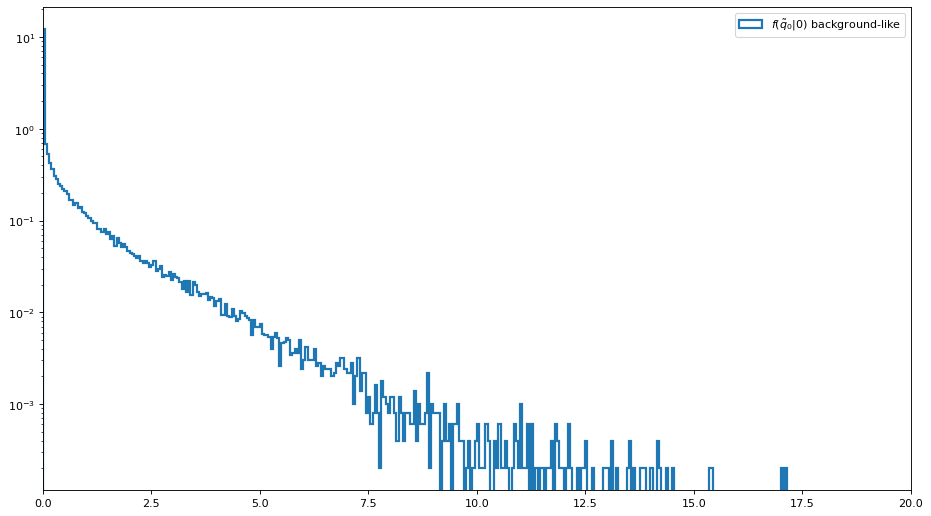

In [298]:
figure(figsize=(14, 8), dpi=80)
histogram_0 = plt.hist(q_0_0s, 
                       bins = np.arange(min(q_0_0s),max(q_0_0s) + 0.5,0.05),
                       histtype = 'step',
                       facecolor='c', 
                       density=True,
                       label=r"$f(\tilde{q}_0|0)$ background-like",
                       linewidth=2)

plt.xlim(0,20)

#plt.axvline(q_obs_0, color='black', linestyle='dotted', linewidth=3, label = "q_obs_0")
plt.yscale('log')

plt.legend()

[ 49.49236419 -55.97210127]


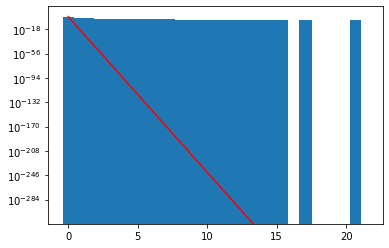

In [297]:
## from scipy.optimize import curve_fit
def func(x, a, b, c, d, e, f, g, h, i , l , m, n):
    return a + (x*b) + (x**2)*c + (x**3)*d + (x**4)*e + (x**5)*f + (x**6)*g + (x**7)*h + (x**8)*i + (x**9)*l+ (x**10)*m + (x**11)*n

def exp(x, a, b):
    return a*np.exp(b*x)
ydata, bins, index = histogram_0
xdata = bins[:len(bins)-1] + 0.025
popt, pcov = curve_fit(exp, xdata=xdata, ydata=ydata, p0=[0, -5])#, -15, -51, -15, -15, -15])
print(popt)

x    = np.linspace(0., 20, 10000)
y    = exp(x, popt[0], popt[1])#, popt[2], popt[3], popt[4], popt[5], popt[6], popt[7], popt[8], popt[9], popt[10], popt[11])


plt.bar(xdata, ydata)
plt.plot(x, y, color = 'red')
plt.yscale('log')

In [299]:
# Finding q0_obs as ratio of Likelihood-functions with mu = 0 and mu = best fit 
q_obs_0 = q_tilde_mu(0, theta_0_obs, mu_max, theta_max)
print("q_obs_0: ",q_obs_0)

# p-value computed integrating analitically the function that fit the distribution above

q_obs_0:  [188.46005869]


In [ ]:
# OLD

In [ ]:
mu    = np.linspace( 0, 1, 1000)
theta = np.linspace(-5, 5, 1000)
likelihood_val_mu = []
likelihood_val_theta = []
for i in mu:
    likelihood_val_mu.append(log_likelihood([i,0]))
    
index_mu = likelihood_val_mu.index(max(likelihood_val_mu))
for i in theta:
    likelihood_val_theta.append(log_likelihood([mu[index_mu],i]))
    
index_theta = likelihood_val_theta.index(max(likelihood_val_theta))

#plt.plot(mu,np.exp(likelihood_val_mu))
mu[index_mu]
plt.plot(mu,np.exp(likelihood_val_mu))
theta[index_theta]
mu[index_mu]
# upper limit for mu: find the mu such that 0.5*q_mu = 1.35, 
# that would correspond to a one-sided CLs+b = 0.05 probability

In [ ]:
def add_nuisance(k = 1.5, s = sim_signal_counts,
                          b = sim_background_counts):
    
    S = s*k**ss.norm.rvs(0, size = s.shape)
    B = b*k**ss.norm.rvs(0, size = b.shape)
    #print(np.mean(S - s), np.mean(B-b))
    
    while(((1*S)+B).any()<0): 
        S = s*k**ss.norm.rvs(0, size = b.shape)
        B = b*k**ss.norm.rvs(0, size = s.shape)
        print('ok')
     
    return S, B